1. What is VGG?

VGG is a type of Convolutional Neural Network (CNN) proposed by the Visual Geometry Group in 2014.

Key characteristics:

Uses small 3×3 convolution kernels throughout the network.

Stacks multiple convolutional layers before each pooling layer.

Applies MaxPooling to reduce spatial dimensions.

Uses fully connected layers at the end for classification.

Activations are passed through ReLU after each convolution.

Variants are named VGG-11, VGG-13, VGG-16, VGG-19 based on the number of learnable layers (Conv + FC).

CIFA10 using VGG 11

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/pankrzysiu/cifar10-python/data")

Skipping, found downloaded files in "./cifar10-python" (use force=True to force download)


In [2]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


0 = airplane
1 = automobile
2 = bird
3 = cat
4 = deer
5 = dog
6 = frog
7 = horse
8 = ship
9 = truck


In [3]:
filename = r"/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/cifar10-python/cifar-10-batches-py/data_batch_"
def load_data():
    images, labels = [], []
    for i in range(1,6):
        with open (filename+str(i), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            images.append(batch[b'data'])
            labels.append(batch[b'labels'])
    
    images = np.concatenate(images, axis = 0)
    labels = np.concatenate(labels, axis =0)
    return images.reshape(-1,3,32,32).astype(np.float32), labels

In [4]:
train_images, train_labels = load_data()




In [5]:
file = r"/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/cifar10-python/cifar-10-batches-py/test_batch"
with open(file, 'rb') as f:
    test = pickle.load(f, encoding='bytes')
    test_images = test[b'data'].reshape(-1,3,32,32).astype(np.float32)
    test_labels = np.array(test[b'labels'])

In [6]:
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean,std)
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return(len(self.images))
    
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        #conver chw to hwc for PIL
        image = np.transpose(image, (1,2,0))
        
        #ensure image is uint8 for PIL(0-255)
        image = Image.fromarray(image.astype(np.uint8))
        
        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [8]:
training_data = CustomDataset(train_images, train_labels, train_transform)
testing_data = CustomDataset(test_images, test_labels, test_transform)

In [9]:
training_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 64, shuffle = False)

In [10]:
data = iter(training_dataloader)
img, lbl = next(data)
print(img.shape)
print(lbl.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [11]:
class MINIVGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #block 1
            nn.Conv2d(3,32,kernel_size=3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            #block2
            nn.Conv2d(32,64,kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            #block3
            nn.Conv2d(64,128,kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            #block4
            nn.Conv2d(128,128,kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,10)
            
        )
        
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MINIVGG().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params = model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-8, weight_decay=1e-4)

In [14]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

In [16]:
epochs = 20
for epoch in range(epochs):
    
    train_loss = 0
    train_acc = 0
    model.train()
    for image, label in training_dataloader:
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        logits = model(image)
        batch_loss = criterion(logits, label)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() * label.size(0)
        _, preds = torch.max(logits, dim = 1)
        train_acc += (preds == label).sum().item()
    
    avg_train_loss = train_loss / len(training_data)
    avg_train_acc = train_acc /len(training_data)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    
    #validation
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testing_dataloader:
                image = image.to(device)
                label = label.to(device)
                logits = model(image)
                batch_loss = criterion(logits, label)
                val_loss += batch_loss.item() * label.size(0)
                _, preds = torch.max(logits, dim = 1)
                val_acc += (preds == label).sum().item()
        
    avg_val_loss = val_loss / len(testing_data)
    avg_val_acc = val_acc /len(testing_data)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)
    
    print(f"Epochs: {epoch+1} / {epochs}")
    print(f"Train Loss: {avg_train_loss:.4}, Train Acc: {avg_train_acc:.4}")
    print(f"Test Loss: {avg_val_loss:.4}, Test Acc: {avg_val_acc:.4}")

Epochs: 1 / 20
Train Loss: 1.668, Train Acc: 0.3844
Test Loss: 1.198, Test Acc: 0.5648
Epochs: 2 / 20
Train Loss: 1.314, Train Acc: 0.517
Test Loss: 1.108, Test Acc: 0.6044
Epochs: 3 / 20
Train Loss: 1.177, Train Acc: 0.5735
Test Loss: 0.9479, Test Acc: 0.6512
Epochs: 4 / 20
Train Loss: 1.084, Train Acc: 0.6103
Test Loss: 0.8562, Test Acc: 0.7083
Epochs: 5 / 20
Train Loss: 1.017, Train Acc: 0.6353
Test Loss: 0.7513, Test Acc: 0.7396
Epochs: 6 / 20
Train Loss: 0.953, Train Acc: 0.6578
Test Loss: 0.7648, Test Acc: 0.7363
Epochs: 7 / 20
Train Loss: 0.9032, Train Acc: 0.6804
Test Loss: 0.7734, Test Acc: 0.7386
Epochs: 8 / 20
Train Loss: 0.8393, Train Acc: 0.7038
Test Loss: 0.6635, Test Acc: 0.7753
Epochs: 9 / 20
Train Loss: 0.7815, Train Acc: 0.7253
Test Loss: 0.607, Test Acc: 0.7975
Epochs: 10 / 20
Train Loss: 0.7237, Train Acc: 0.7496
Test Loss: 0.5961, Test Acc: 0.8008
Epochs: 11 / 20
Train Loss: 0.6591, Train Acc: 0.7745
Test Loss: 0.5756, Test Acc: 0.8065
Epochs: 12 / 20
Train Loss: 0

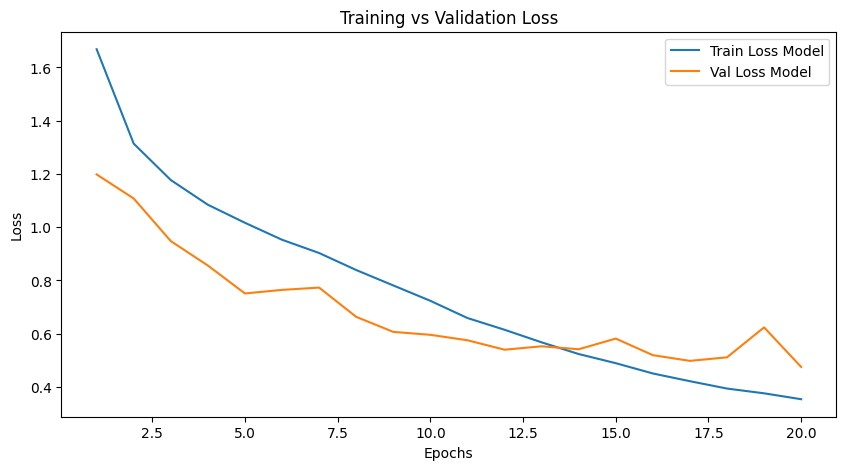

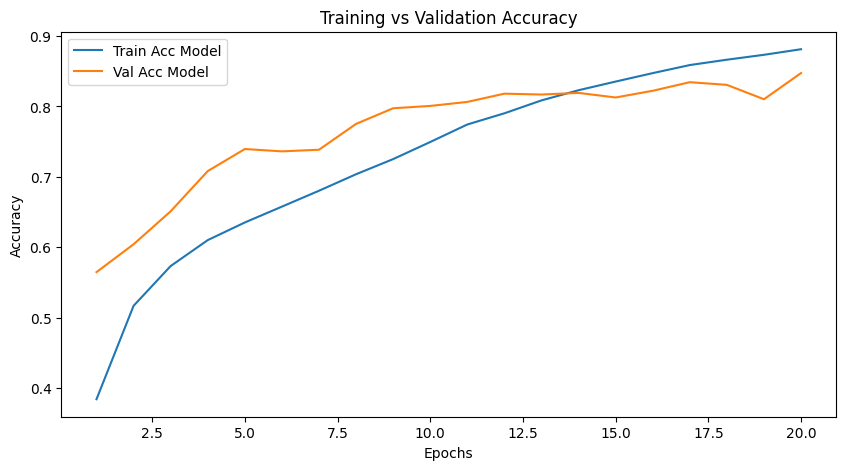

In [17]:
epochs_range = range(1, epochs + 1)

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label="Train Loss Model")
plt.plot(epochs_range, val_losses, label="Val Loss Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accs, label="Train Acc Model")
plt.plot(epochs_range, val_accs, label="Val Acc Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()